In [32]:
from preprocessing import load_reviews
from concepts import ConceptExtractor, conceptualize_df, visualize_concept_wordcloud
from experiments import run_experiment
from features import SentimentFeatures
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import random

# Setup

In [33]:
num_concepts = 3000
num_important_features = int(num_concepts * 0.2)

seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train_df, test_df, val_df = load_reviews("word", seed)

## Loading IMDb Reviews Dataset

INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split train, from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split test, from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
2025-11-28 14:55:52.459556: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting wit

**Total reviews before deduplication:** 50000

**Total reviews after deduplication:** 49582

**Train / Validation / Test sizes:**

,split,count
0,train,29749
1,val,9916
2,test,9917


### Sample Reviews

**Train Set:**

,review,sentiment,units
19067,As with all environmentally aware films from t...,1,[as with all environmentally aware films from ...
33476,I completely understand the historical signifi...,0,[i completely understand the historical signif...
26034,First of all this is one of the worst soft-cor...,0,[first of all this is one of the worst soft co...
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,[some weeks ago at a movie theater i saw a mov...
20837,As someone who has seen and followed Hartley's...,1,[as someone who has seen and followed hartley ...


**Test Set:**

,review,sentiment,units
6092,This movie is an idiotic attempt at some kind ...,0,[this movie is an idiotic attempt at some kind...
23020,ANCHORS AWEIGH is an entertaining MGM musical ...,1,[anchors aweigh is an entertaining mgm musical...
13778,One of the best movies I ever saw was an Irish...,1,[one of the best movies i ever saw was an iris...
16434,We saw this at one of the local art movie thea...,1,[we saw this at one of the local art movie the...
4218,I am compelled to write a review of this IMAX ...,0,[i am compelled to write a review of this imax...


**Validation Set:**

,review,sentiment,units
8437,Style but no substance. Not as funny as it sho...,0,"[style but no substance, not as funny as it sh..."
43138,"Not well done at all, the whole movie was just...",0,[not well done at all the whole movie was just...
45198,I am really sad that that this film has got so...,1,[i am really sad that that this film has got s...
20751,This is one of my favorite family movies. Love...,1,"[this is one of my favorite family movies, lov..."
45035,"When I first saw this movie, I said to myself,...",0,[when i first saw this movie i said to myself ...


# Concepts

In [35]:
extractor = ConceptExtractor()
concepts = extractor.train_concepts(train_df["units"].explode().tolist() , num_concepts)

INFO:concepts:Using device: cuda
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:concepts:Found 308763 unique units.
INFO:concepts:Computing embeddings...
Batches:   2%|▏         | 7/302 [01:01<42:53,  8.72s/it]  


KeyboardInterrupt: 

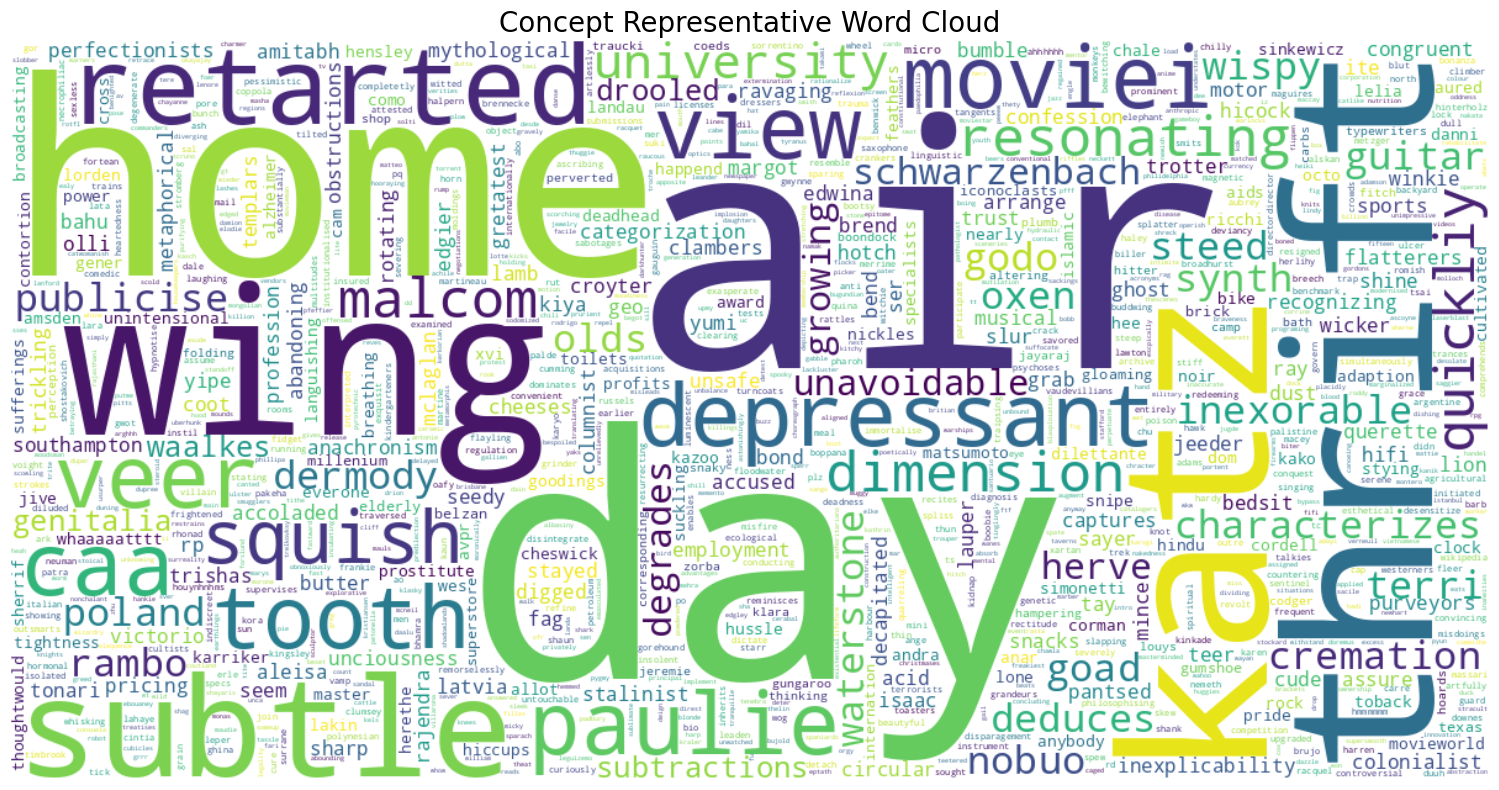

In [ ]:
visualize_concept_wordcloud(concepts["concept_units"], num_concepts)

In [ ]:
conceptualize_df(train_df, "units", concepts["unit_to_cluster"])
train_df.head()

,review,sentiment,units,concept_ids
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...","[2270, 704, 2978, 285, 1412, 1166, 1606, 1116,..."
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...","[1116, 403, 478, 1116, 1251, 2679, 730, 1544, ..."
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...","[1432, 730, 2978, 730, 62, 2890, 730, 1116, 20..."
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...","[2021, 2564, 357, 2508, 2645, 2995, 2995, 1116..."
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...","[2270, 1323, 157, 2630, 351, 1271, 2451, 1566,..."


In [ ]:
# Map test words
test_unit_map = extractor.map_units_to_clusters(test_df["units"].explode().tolist(), concepts["cluster_centers"])

INFO:concepts:Mapping 51652 units to nearest clusters...
Batches: 100%|██████████| 51/51 [00:03<00:00, 14.44it/s]


In [ ]:
conceptualize_df(test_df, "units", test_unit_map)
test_df.head()

,review,sentiment,units,concept_ids
6092,This movie is an idiotic attempt at some kind ...,0,"[this, movie, is, an, idiotic, attempt, at, so...","[1116, 2995, 62, 2645, 2320, 2225, 2508, 2056,..."
23020,ANCHORS AWEIGH is an entertaining MGM musical ...,1,"[anchors, aweigh, is, an, entertaining, mgm, m...","[531, 1526, 62, 2645, 1644, 608, 142, 1365, 26..."
13778,One of the best movies I ever saw was an Irish...,1,"[one, of, the, best, movies, i, ever, saw, was...","[2890, 561, 2021, 2399, 2995, 1116, 2660, 1751..."
16434,We saw this at one of the local art movie thea...,1,"[we, saw, this, at, one, of, the, local, art, ...","[2021, 1751, 1116, 2508, 2890, 561, 2021, 775,..."
4218,I am compelled to write a review of this IMAX ...,0,"[i, am, compelled, to, write, a, review, of, t...","[1116, 1160, 1655, 1845, 2260, 2645, 2994, 561..."


# Feature selection

In [ ]:
an = SentimentFeatures()
an.fit(train_df["concept_ids"], train_df["sentiment"])

an.plot_top(concepts["concept_units"])

KeyboardInterrupt: 

In [ ]:
train_df = an.add_top_features(train_df, n=num_important_features)
test_df  = an.add_top_features(test_df, n=num_important_features)

# Models

In [ ]:
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...","[2270, 704, 2978, 285, 1412, 1166, 1606, 1116,...","[2270, 285, 1412, 1166, 1606, 1116, 1705, 2645...","[2978, 2630, 2480, 1068, 730, 730, 62, 1230, 1...","[2270, 2978, 285, 1412, 1166, 1606, 1116, 1705..."
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...","[1116, 403, 478, 1116, 1251, 2679, 730, 1544, ...","[1116, 1116, 1251, 1116, 2645, 678, 1116, 1271...","[403, 2679, 730, 1544, 1365, 1365, 147, 62, 11...","[1116, 403, 1116, 1251, 2679, 730, 1544, 1116,..."
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...","[1432, 730, 2978, 730, 62, 2890, 730, 1116, 20...","[2890, 1116, 2936, 1116, 2660, 351, 2942, 1116...","[730, 2978, 730, 62, 730, 2006, 1642, 1845, 26...","[730, 2978, 730, 62, 2890, 730, 1116, 2006, 16..."
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...","[2021, 2564, 357, 2508, 2645, 2995, 2995, 1116...","[2564, 357, 2645, 1116, 1751, 2645, 936, 1116,...","[2021, 2508, 2995, 2995, 2995, 730, 2903, 2630...","[2021, 2564, 357, 2508, 2645, 2995, 2995, 1116..."
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...","[2270, 1323, 157, 2630, 351, 1271, 2451, 1566,...","[2270, 157, 351, 1271, 1566, 1705, 90, 2056, 1...","[1323, 2630, 2451, 1932, 730, 730, 730, 1845, ...","[2270, 1323, 157, 2630, 351, 1271, 2451, 1566,..."


# TF-IDF

In [ ]:
y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

In [ ]:
train_df["concept_ids"] = train_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_positive_features"] = train_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_negative_features"] = train_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_important_features"] = train_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...",2270 704 2978 285 1412 1166 1606 1116 1705 117...,2270 285 1412 1166 1606 1116 1705 2645 11 285 ...,2978 2630 2480 1068 730 730 62 1230 190 1323 1...,2270 2978 285 1412 1166 1606 1116 1705 2630 26...
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...",1116 403 478 1116 1251 2679 730 1544 1116 1507...,1116 1116 1251 1116 2645 678 1116 1271 1116 12...,403 2679 730 1544 1365 1365 147 62 1183 2995 1...,1116 403 1116 1251 2679 730 1544 1116 1365 136...
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...",1432 730 2978 730 62 2890 730 1116 2006 2705 1...,2890 1116 2936 1116 2660 351 2942 1116 1623 29...,730 2978 730 62 730 2006 1642 1845 2630 730 30...,730 2978 730 62 2890 730 1116 2006 1642 1845 2...
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...",2021 2564 357 2508 2645 2995 2995 1116 1751 26...,2564 357 2645 1116 1751 2645 936 1116 1116 146...,2021 2508 2995 2995 2995 730 2903 2630 1932 12...,2021 2564 357 2508 2645 2995 2995 1116 1751 26...
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...",2270 1323 157 2630 351 1271 2451 1566 1705 27 ...,2270 157 351 1271 1566 1705 90 2056 1956 1116 ...,1323 2630 2451 1932 730 730 730 1845 2309 468 ...,2270 1323 157 2630 351 1271 2451 1566 1705 90 ...


In [ ]:
test_df["concept_ids"] = test_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_positive_features"] = test_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_negative_features"] = test_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_important_features"] = test_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
6092,This movie is an idiotic attempt at some kind ...,0,"[this, movie, is, an, idiotic, attempt, at, so...",1116 2995 62 2645 2320 2225 2508 2056 1042 561...,1116 2645 2056 2936 2645 2773 1243 2645 1449 1...,2995 62 2320 2225 2508 1042 561 2656 62 1845 6...,1116 2995 62 2645 2320 2225 2508 2056 1042 561...
23020,ANCHORS AWEIGH is an entertaining MGM musical ...,1,"[anchors, aweigh, is, an, entertaining, mgm, m...",531 1526 62 2645 1644 608 142 1365 2699 561 20...,1526 2645 608 142 1861 1116 1243 578 2942 2231...,62 1644 1365 561 2021 147 1365 1408 62 606 190...,1526 62 2645 1644 608 142 1365 561 2021 147 18...
13778,One of the best movies I ever saw was an Irish...,1,"[one, of, the, best, movies, i, ever, saw, was...",2890 561 2021 2399 2995 1116 2660 1751 561 264...,2890 2399 1116 2660 1751 2645 1292 1736 1116 1...,561 2021 2995 561 2995 190 708 854 2021 2021 2...,2890 561 2021 2399 2995 1116 2660 1751 561 264...
16434,We saw this at one of the local art movie thea...,1,"[we, saw, this, at, one, of, the, local, art, ...",2021 1751 1116 2508 2890 561 2021 775 2808 299...,1751 1116 2890 2808 2942 2305 236 2645 2894 27...,2021 2508 561 2021 2995 2995 2021 561 561 590 ...,2021 1751 1116 2508 2890 561 2021 2808 2995 29...
4218,I am compelled to write a review of this IMAX ...,0,"[i, am, compelled, to, write, a, review, of, t...",1116 1160 1655 1845 2260 2645 2994 561 1116 86...,1116 2645 1116 2312 2645 1116 2793 1805 867 14...,1160 1655 1845 2260 2994 561 1230 561 1234 202...,1116 1160 1655 1845 2260 2645 2994 561 1116 23...


In [ ]:
# Main concept IDs
tfidf_main = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_all_train = tfidf_main.fit_transform(train_df["concept_ids"])
X_all_test  = tfidf_main.transform(test_df["concept_ids"])

# Positive features
tfidf_pos = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_pos_train = tfidf_pos.fit_transform(train_df["concept_ids_positive_features"])
X_pos_test  = tfidf_pos.transform(test_df["concept_ids_positive_features"])

# Negative features
tfidf_neg = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_neg_train = tfidf_neg.fit_transform(train_df["concept_ids_negative_features"])
X_neg_test  = tfidf_neg.transform(test_df["concept_ids_negative_features"])

# Important features
tfidf_imp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_imp_train = tfidf_neg.fit_transform(train_df["concept_ids_important_features"])
X_imp_test = tfidf_neg.transform(test_df["concept_ids_important_features"])

In [ ]:
# Prepare data in the required dictionary format
X_sets_train = {
    'all': X_all_train,
    'pos': X_pos_train, 
    'neg': X_neg_train,
    'important': X_imp_train
}

X_sets_test = {
    'all': X_all_test,
    'pos': X_pos_test,
    'neg': X_neg_test,
    'important': X_imp_test
}

# Verify shapes
print("\nData shapes:")
for key in X_sets_train:
    print(f"Train {key}: {X_sets_train[key].shape}")
for key in X_sets_test:
    print(f"Test {key}: {X_sets_test[key].shape}")

print(f"\nLabel shapes: y_train {y_train.shape}, y_test {y_test.shape}")


Data shapes:
Train all: (29749, 50000)
Train pos: (29749, 50000)
Train neg: (29749, 50000)
Train important: (29749, 50000)
Test all: (9917, 50000)
Test pos: (9917, 50000)
Test neg: (9917, 50000)
Test important: (9917, 50000)

Label shapes: y_train (29749,), y_test (9917,)


## Linear-SVM

LinearSVM 'all' initialized with C=1.0
LinearSVM 'all' trained.


## ALL Evaluation

**Accuracy:** 0.8555

,precision,recall,f1-score,support
0,0.81911,0.91113,0.86267,4940
1,0.90072,0.80028,0.84754,4977
accuracy,0.85550,0.85550,0.85550,0
macro avg,0.85992,0.85571,0.85511,9917
weighted avg,0.86007,0.85550,0.85508,9917


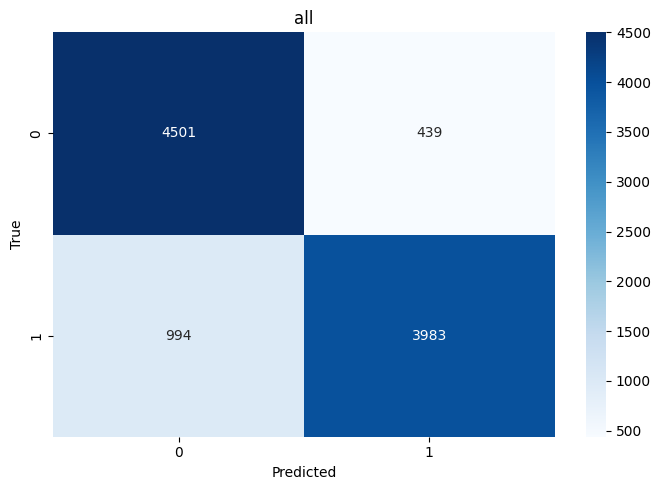

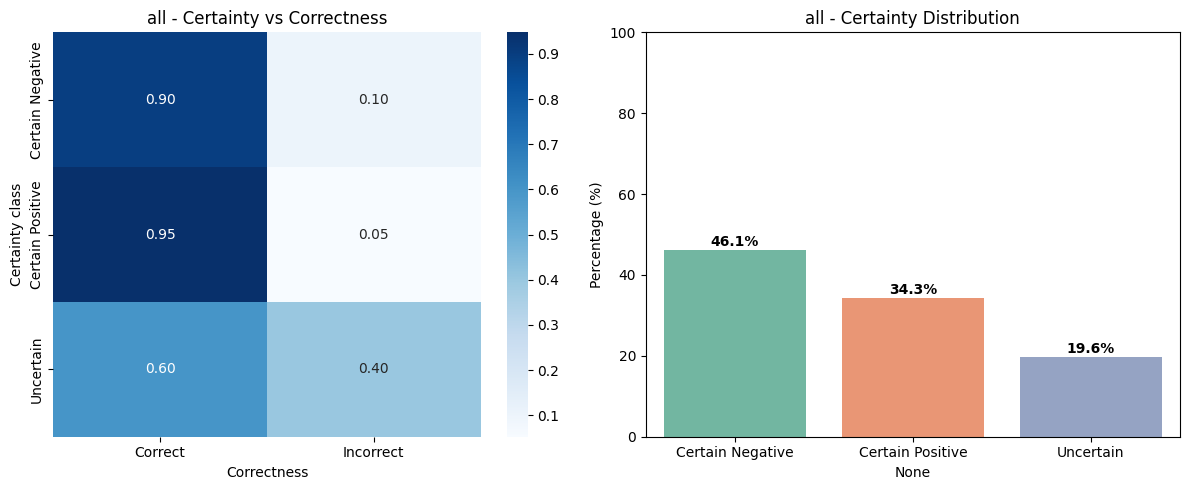

## ALL Model — Unsure Predictions

,probability,true_label,text
0,0.5283,1,ANCHORS AWEIGH is an entertaining MGM musical ...
1,0.4919,1,One of the best movies I ever saw was an Irish...
2,0.5453,1,At the beginning it was almost a shock to see ...
3,0.3377,0,What we know of Caravaggio suggests a struttin...
4,0.3290,1,While it was filmed at a Florida National Guar...


## ALL Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.4919,1,0,One of the best movies I ever saw was an Irish...
1,0.3290,1,0,While it was filmed at a Florida National Guar...
2,0.1175,1,0,This film is to my mind the weakest film in th...
3,0.3729,1,0,"I searched for this movie for years, apparentl..."
4,0.2294,1,0,Why all the negative reviews??? You didn't exp...


LinearSVM 'pos' initialized with C=1.0
LinearSVM 'pos' trained.


## POS Evaluation

**Accuracy:** 0.7381

,precision,recall,f1-score,support
0,0.76912,0.67773,0.72054,4940
1,0.71387,0.79807,0.75363,4977
accuracy,0.73813,0.73813,0.73813,0
macro avg,0.74150,0.73790,0.73709,9917
weighted avg,0.74140,0.73813,0.73715,9917


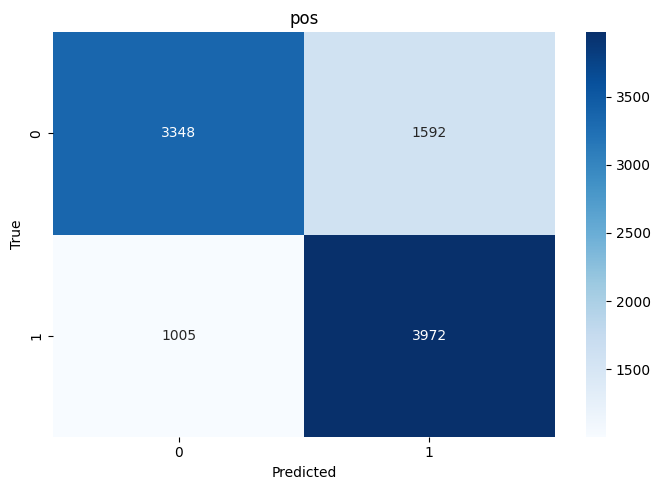

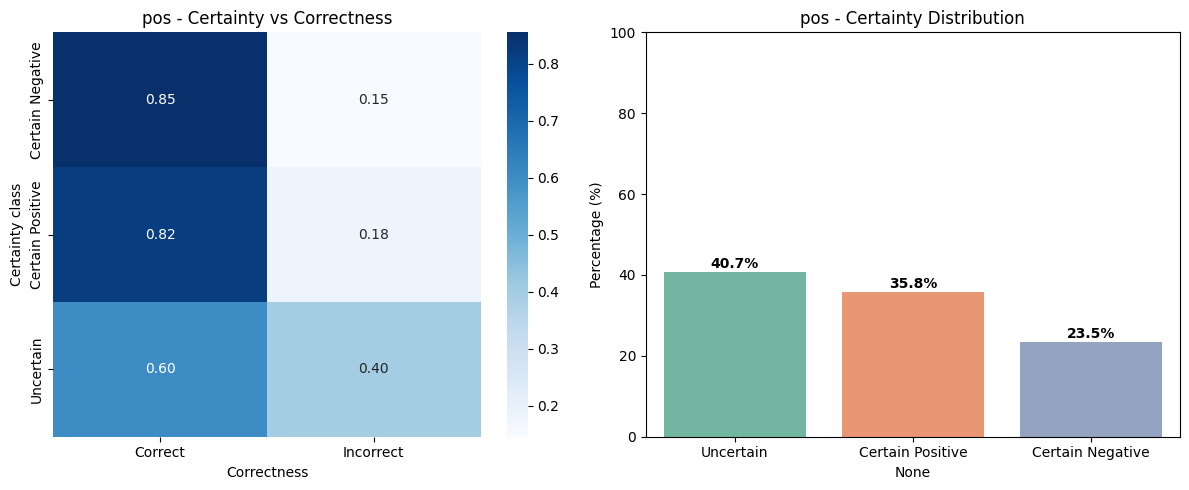

## POS Model — Unsure Predictions

,probability,true_label,text
0,0.3908,0,This movie is an idiotic attempt at some kind ...
1,0.6501,0,I am compelled to write a review of this IMAX ...
2,0.4241,1,At the beginning it was almost a shock to see ...
3,0.6527,0,This movie treads on very familiar ground -- t...
4,0.5204,1,Dudley Moore is fantastic in this largley unkn...


## POS Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.6501,0,1,I am compelled to write a review of this IMAX ...
1,0.4241,1,0,At the beginning it was almost a shock to see ...
2,0.6527,0,1,This movie treads on very familiar ground -- t...
3,0.8423,0,1,What we know of Caravaggio suggests a struttin...
4,0.6586,0,1,George Burns returns as the joshing Almighty a...


LinearSVM 'neg' initialized with C=1.0
LinearSVM 'neg' trained.


## NEG Evaluation

**Accuracy:** 0.7917

,precision,recall,f1-score,support
0,0.78132,0.80789,0.79439,4940
1,0.80266,0.77557,0.78888,4977
accuracy,0.79167,0.79167,0.79167,0
macro avg,0.79199,0.79173,0.79163,9917
weighted avg,0.79203,0.79167,0.79162,9917


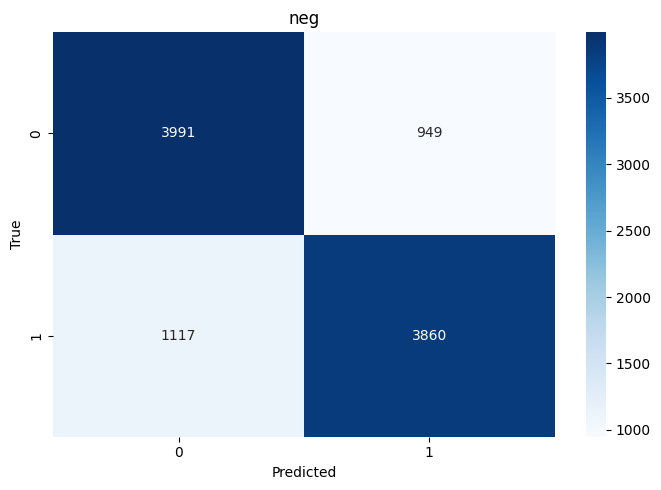

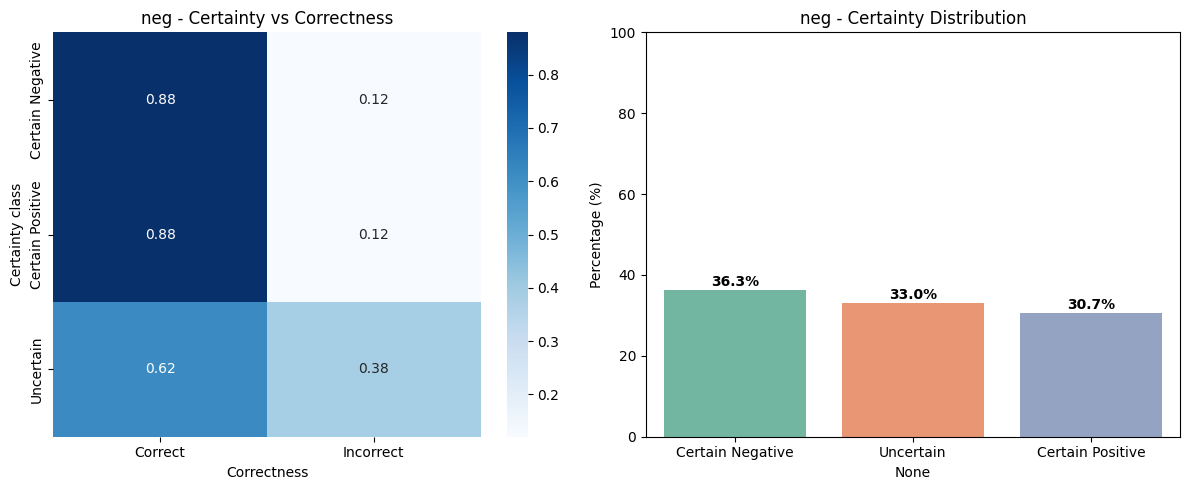

## NEG Model — Unsure Predictions

,probability,true_label,text
0,0.5798,1,ANCHORS AWEIGH is an entertaining MGM musical ...
1,0.3212,1,"Bill and Ted are back, only this time an evil ..."
2,0.5710,0,What we know of Caravaggio suggests a struttin...
3,0.3503,1,I've been looking forward to the release of th...
4,0.4625,1,Race Against Fear has to be one of the most mo...


## NEG Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.1840,1,0,One of the best movies I ever saw was an Irish...
1,0.3212,1,0,"Bill and Ted are back, only this time an evil ..."
2,0.7447,0,1,This movie treads on very familiar ground -- t...
3,0.5710,0,1,What we know of Caravaggio suggests a struttin...
4,0.3503,1,0,I've been looking forward to the release of th...


LinearSVM 'important' initialized with C=1.0
LinearSVM 'important' trained.


## IMPORTANT Evaluation

**Accuracy:** 0.8468

,precision,recall,f1-score,support
0,0.80748,0.90931,0.85537,4940
1,0.89711,0.78481,0.83721,4977
accuracy,0.84683,0.84683,0.84683,0
macro avg,0.85229,0.84706,0.84629,9917
weighted avg,0.85246,0.84683,0.84626,9917


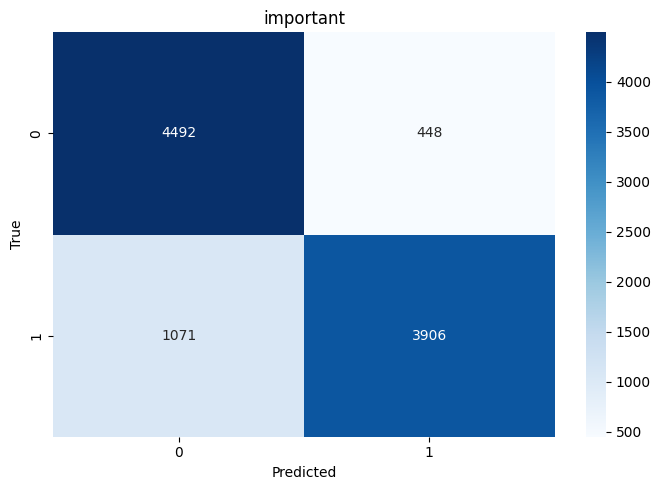

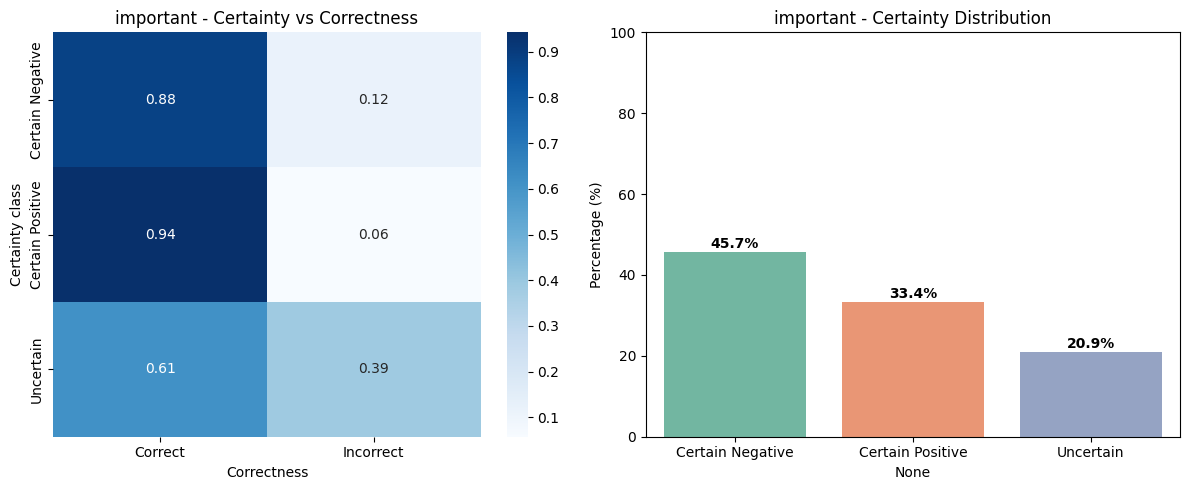

## IMPORTANT Model — Unsure Predictions

,probability,true_label,text
0,0.5755,1,ANCHORS AWEIGH is an entertaining MGM musical ...
1,0.5180,1,One of the best movies I ever saw was an Irish...
2,0.4686,1,At the beginning it was almost a shock to see ...
3,0.3578,0,What we know of Caravaggio suggests a struttin...
4,0.6663,1,While it was filmed at a Florida National Guar...


## IMPORTANT Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.4686,1,0,At the beginning it was almost a shock to see ...
1,0.1522,1,0,This film is to my mind the weakest film in th...
2,0.2887,1,0,"I searched for this movie for years, apparentl..."
3,0.1477,1,0,Why all the negative reviews??? You didn't exp...
4,0.4290,1,0,In the opening scenes of this movie a man shot...


# Ensemble Accuracy: **0.8538**

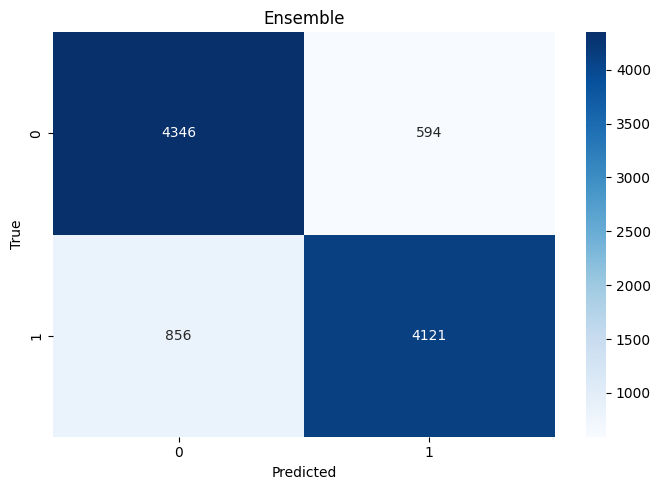

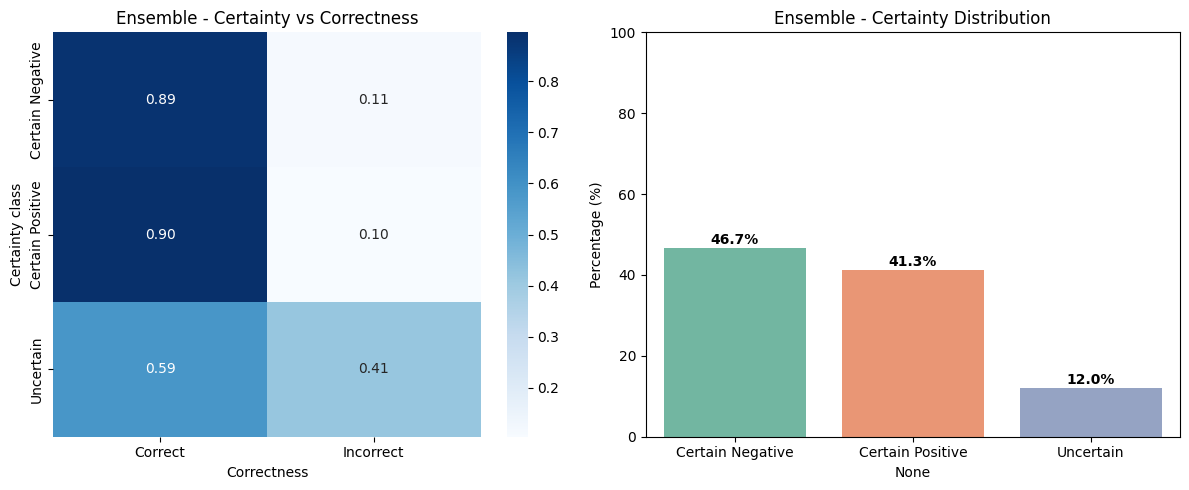

## Ensemble — Unsure Predictions

,probability,true_label,text
0,0.4919,1,One of the best movies I ever saw was an Irish...
1,0.5453,1,At the beginning it was almost a shock to see ...
2,0.3729,1,"I searched for this movie for years, apparentl..."
3,0.6297,1,Some spoilers If you are a big horror movie fa...
4,0.3563,1,In the opening scenes of this movie a man shot...


## Ensemble — Misclassified Predictions

,probability,true_label,predicted,text
0,0.4919,1,0,One of the best movies I ever saw was an Irish...
1,0.8423,0,1,What we know of Caravaggio suggests a struttin...
2,0.1175,1,0,This film is to my mind the weakest film in th...
3,0.3729,1,0,"I searched for this movie for years, apparentl..."
4,0.2294,1,0,Why all the negative reviews??? You didn't exp...


## Train/Test Feature Overlap Check

✅ No identical TF-IDF rows detected in 'all'

✅ No identical TF-IDF rows detected in 'pos'

✅ No identical TF-IDF rows detected in 'neg'

✅ No identical TF-IDF rows detected in 'important'

,train_test_overlap
all,0
pos,0
neg,0
important,0


In [ ]:
results = run_experiment(X_sets_train, y_train, X_sets_test, y_test, test_df["review"], "linear-svm")